In [1]:
%matplotlib notebook

from __future__ import division
import math
import sys
import os
import csv
import sqlite3
import pandas
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

sys.path.append('.')
import scripts2d.utils as u
from wde.estimator import WaveletDensityEstimator
from wde.simple_estimator import SimpleWaveletDensityEstimator
from wde.common import np_mult
from wde.thresholding import soft_threshold, hard_threshold, block_threshold


In [3]:
def contour_plot_them(dists, data, title='Contour', fname=None):
    fig = plt.figure(figsize=(4, 4), dpi=144)
    X = np.linspace(0.0,1.0, num=75)
    Y = np.linspace(0.0,1.0, num=75)
    XX, YY = np.meshgrid(X, Y)
    minz, maxz = float('inf'), float('-inf')
    Zs = []
    for dist in dists:
        Z = dist.pdf((XX, YY))
        Zs.append(Z)
        minz = min(minz, Z.min())
        maxz = max(maxz, Z.max())
    levels = np.linspace(minz, maxz, num=10)
    cmap = cm.get_cmap('BuGn')
    if minz == 0:
        levels = np.linspace(minz + (maxz-minz)/100, maxz, num=10)
        cmap.set_under("magenta")
    plt.contour(XX, YY, Z[0], alpha=0.4, linestyles='solid', levels=levels, extend='min', cmap=cmap)
    plt.contour(XX, YY, Z[1], alpha=1.0, linestyles='solid', levels=levels, extend='min', cmap=cmap)
    linestyles = enumerate(['solid','dashed'])
    alphas = enumerate([0.4,1.0])
    for dist, Z in zip(dists, Zs):
        linestyle = next(linestyles)[1]
        cs = plt.contour(XX, YY, Z, alpha=(next(alphas)[1]), linestyles=linestyle, levels=levels, extend='min', cmap=cmap)
        if linestyle == 'dashed':
            plt.clabel(cs, inline=1, fontsize=10)
    plt.scatter(data[:,0], data[:,1], s=1, alpha=0.4)
    #avg = data.mean(axis=0)
    #plt.scatter(avg[0],avg[1], s=10, marker='+', color='r')
    plt.title(title)
    if fname is not None:
        plt.savefig('data/%s' % fname, pad_inches=0.0, orientation='portrait', frameon=False)
    plt.show()
    
def plot_it(dist, fname=None):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X = np.linspace(0.0,1.0, num=75)
    Y = np.linspace(0.0,1.0, num=75)
    XX, YY = np.meshgrid(X, Y)
    Z = dist.pdf((XX, YY))
    surf = ax.plot_surface(XX, YY, Z, edgecolors='k', linewidth=0.5, cmap=cm.get_cmap('BuGn'))
    #ax.set_zlim(0, 5)
    if fname is not None:
        plt.savefig('data/%s' % fname, pad_inches=0.0, orientation='portrait', frameon=False)
    plt.show()


ISE: 5.16495210068


<IPython.core.display.Javascript object>


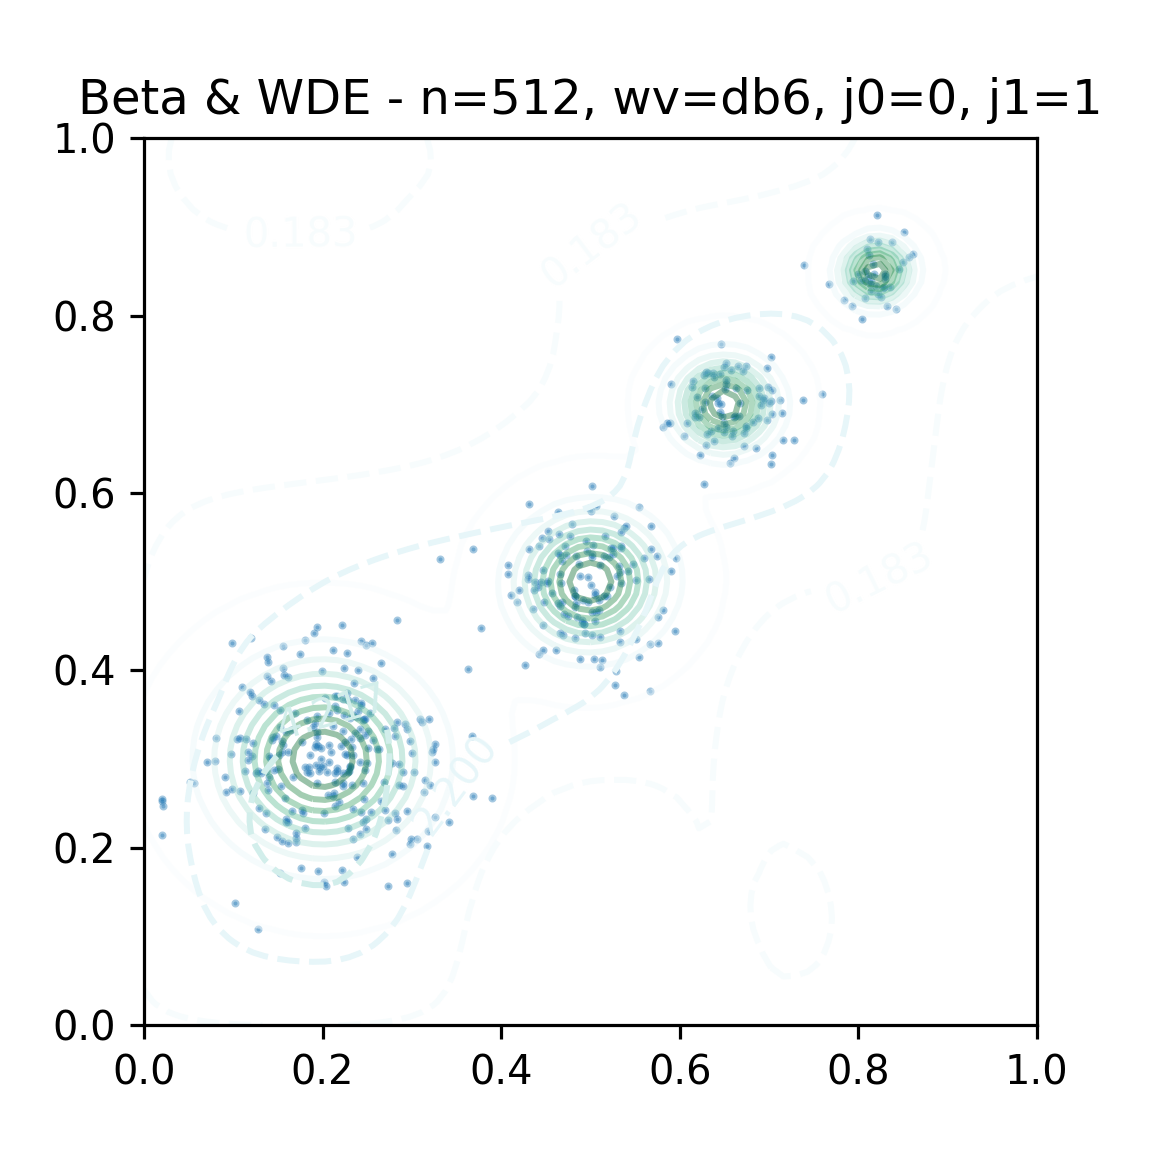

In [11]:
wde_glob = None
def p11(n, wv, **kwargs):
    global wde_glob
    dist = u.dist_from_code('mix3')
    data = dist.rvs(n)
    wde = SimpleWaveletDensityEstimator(wv, **kwargs) #WaveletDensityEstimator(wv, **kwargs)
    #print data.mean(axis=0)
    wde.fit(data)
    XX, YY = u.mise_mesh()
    Z = dist.pdf((XX, YY))
    ise = u.calc_ise(wde.pdf, Z)
    print 'ISE:', ise
    contour_plot_them((dist,wde), data, 'Beta & WDE - n=%d, wv=%s, j0=%d, j1=%d' % (n, wv, kwargs['j0'], kwargs['j1']))
    #plot_it(wde)
    wde_glob = wde
p11(512, 'db6', j0=0, j1=1)

In [12]:
def error_func(params, ns, ises):
    a, b1, b2, k = params
    ys = (ns ** (-k)) * b1 + (ns ** (-1.0)) * b2 + a
    residuals = ys - ises
    return (residuals * residuals).mean()

def regression_for():
    points = pandas.read_csv('data/ise.csv')
    a = points['ise'].mean()
    k = 0.8
    b = (points['ise'].sum() - points['n'].size * a) / (points['n'] ** (-k)).sum()
    ini_guess = (a, b, b, k)
    reqs = [
        # minx < load_a < maxx
        {
            'type': 'ineq',
            'fun': lambda params: params[0] # a > 0
        },
        {
            'type': 'ineq',
            'fun': lambda params: params[1] # b1 > 0
        },
        {
            'type': 'ineq',
            'fun': lambda params: params[2] # b2 > 0
        },
        {
            'type': 'ineq',
            'fun': lambda params: params[3] # k > 0
        }
    ]
    result = minimize(
        error_func,
        ini_guess,
        args=(points['n'], points['ise']),
        constraints=reqs,
        method='COBYLA',
        options=dict(maxiter=10000))
    if result.success:
        print 'err>', result.fun
        print 'solution>', result.x
    else:
        print 'failure>', result.message
    a, b1, b2, k = result.x
    ys = (points['n'] ** (-k)) * b1 + (points['n'] ** (-1.0)) * b2 + a
    plt.figure()
    plt.scatter(points['n'], points['ise'], s=1)
    plt.plot(points['n'], ys, 'k:')
    plt.show()
    
#regression_for()

In [13]:
# single coefficient
def plot_wave_fun(dist, wde, jpow, qx, zs):
    wfun = wde.wave_funs[qx]
    supp = wfun.support + zs
    ff = np_mult(supp[1,:] - supp[0,:])
    X = np.linspace(supp[0,0], supp[1,0], num=256)
    Y = np.linspace(supp[0,1], supp[1,1], num=256)
    XX, YY = np.meshgrid(X, Y) # X,Y
    cmap = cm.get_cmap('BuGn')
    Z = wfun(jpow, np.array(zs), (XX, YY))
    nn = reduce(lambda x, y: (x-1) * (y-1), Z.shape)
    ff3 = (Z*Z).sum()/(nn) * ff
    print math.sqrt(ff3)
    Z2 = np.sqrt(dist.pdf((XX, YY)))
    print (Z * Z2).sum()/(nn) * ff / math.sqrt(ff3)
    return
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(XX, YY, Z, edgecolors='k', linewidth=0.5, cmap=cmap)
    plt.show()
    
def p7(n, wv, **kwargs):
    global wde_glob
    dist = u.dist_from_code('beta')
    wde = WaveletDensityEstimator(wv, **kwargs)
    #print data.mean(axis=0)
    wde.calc_wavefuns(2)
    jpow = 2 ** kwargs['j0']
    plot_wave_fun(dist, wde, jpow, (0,1), (0,0))
    for i in range(20):
        data = dist.rvs(n)
        wde.fit(data)
        print i, ',', wde.coeffs[0][(0,1)][(0,0)]
    
#p7(2000, 'db6', j0=0, j1=1)